<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_r52.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd gdrive/My\ Drive/MIT/gcn_explainability/

/content/gdrive/My Drive/MIT/gcn_explainability


In [3]:
!git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/albert-yue/gcn-explanability
   b9a08fa..6006d78  master     -> origin/master
Updating b9a08fa..6006d78
Fast-forward
 notebooks/6864_final_project_r8.ipynb | 5923 +++++++++++++++++++++++++++++++++
 1 file changed, 5923 insertions(+)
 create mode 100644 notebooks/6864_final_project_r8.ipynb


# Set up Vocabulary and Labels

In [0]:
from src.data import save_all_labels

save_all_labels('data/r52-labels.txt', 'data/train-r52.txt', 'data/test-r52.txt')

In [0]:
from tqdm.auto import tqdm

def save_vocabulary(out_path, train_path, test_path, doc_freq_threshold=5):
    word_freqs = {}  # counting num of docs
    for data_path in [train_path, test_path]:
        with open(data_path, 'r') as f:
            for line in tqdm(f.readlines()):
                line = line.strip()
                _, text = line.split('\t')
                words = text.split()
                for w in set(words):
                    w = w.strip()
                    if w in word_freqs:
                        word_freqs[w] += 1
                    else:
                        word_freqs[w] = 1
    vocab = []
    for w, freq in word_freqs.items():
        if freq >= doc_freq_threshold:
            vocab.append(w)
    with open(out_path, 'w+') as f:
        f.write('\n'.join(vocab))

In [6]:
save_vocabulary('data/r52-vocabulary.txt', 'data/train-r52.txt', 'data/test-r52.txt')

# Training

In [0]:
from src.data import Corpus, get_data, get_vocabulary, get_labels
from src.models.gcn import GCN
from src.preprocessing import clean_text, build_adj_matrix, normalize_adj
from src.train import train, evaluate, accuracy

In [0]:
seed = 0
val_split = 0.1

vocab = get_vocabulary('data/r52-vocabulary.txt')
labels = get_labels('data/r52-labels.txt')
corpus = get_data('data/train-r52.txt', labels)
test_corpus = get_data('data/test-r52.txt', labels)

# Split validation set
corpus.shuffle(seed)
len_train = int(len(corpus) * (1 - val_split))
train_corpus = Corpus(corpus[:len_train])
val_corpus = Corpus(corpus[len_train:])

num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# Mask out unknown words
clean_text(corpus, vocab)
clean_text(test_corpus, vocab)

In [22]:
train_adj_matrix = build_adj_matrix(train_corpus, vocab, num_documents, doc_offset=0)
val_adj_matrix = build_adj_matrix(val_corpus, vocab, num_documents, doc_offset=len(train_corpus))
test_adj_matrix = build_adj_matrix(test_corpus, vocab, num_documents, doc_offset=len(train_corpus) + len(val_corpus))

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(train_adj_matrix, 'data/r52_train_adj_matrix.pt')
save_sparse_tensor(val_adj_matrix, 'data/r52_val_adj_matrix.pt')
save_sparse_tensor(test_adj_matrix, 'data/r52_test_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

train_adj_matrix = load_sparse_tensor('data/r52_train_adj_matrix.pt')
val_adj_matrix = load_sparse_tensor('data/r52_val_adj_matrix.pt')
test_adj_matrix = load_sparse_tensor('data/r52_test_adj_matrix.pt')

In [0]:
train_adj_matrix = normalize_adj(train_adj_matrix)
val_adj_matrix = normalize_adj(val_adj_matrix)
test_adj_matrix = normalize_adj(test_adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [27]:
%time train_losses, val_losses = train(model, train_adj_matrix, val_adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, plot_every=5, print_every=10, save_path='r52_train.pt')

Epoch 0
Train mean cross-entropy: 3.951444625854492
Validation mean cross-entropy: 3.9492740631103516
Epoch 10
Train mean cross-entropy: 3.919527530670166
Validation mean cross-entropy: 3.9208428859710693
Epoch 20
Train mean cross-entropy: 3.8642079830169678
Validation mean cross-entropy: 3.866250514984131
Epoch 30
Train mean cross-entropy: 3.770392894744873
Validation mean cross-entropy: 3.7733280658721924
Epoch 40
Train mean cross-entropy: 3.633861541748047
Validation mean cross-entropy: 3.63389253616333
Epoch 50
Train mean cross-entropy: 3.4479832649230957
Validation mean cross-entropy: 3.451148748397827
Epoch 60
Train mean cross-entropy: 3.221968173980713
Validation mean cross-entropy: 3.246185302734375
Epoch 70
Train mean cross-entropy: 2.977728843688965
Validation mean cross-entropy: 3.0507004261016846
Epoch 80
Train mean cross-entropy: 2.722362756729126
Validation mean cross-entropy: 2.8916563987731934
Epoch 90
Train mean cross-entropy: 2.550133228302002
Validation mean cross-en

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("R52 Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

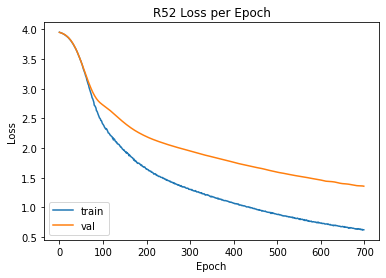

In [29]:
plot_loss(train_losses, val_losses)

In [30]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, test_adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.4887071651090343
